### Workflow

Figma diagram: https://www.figma.com/file/PFKdJO3HTIcM9g4nmVONCT/HRA-Data-Explorer?type=whiteboard&node-id=1%3A108&t=XGoN91s7IKbyZ7xk-1

Below is the information about the diagram:

1. Dataset Collections:
The process begins with RUI Registered Tissue datasets, a collection of tissue datasets registered in a specific repository or database.
These datasets are linked to specific Organs and Anatomical Structures.

2. Dataset Processing:
The datasets are processed to produce Anatomical Structures/Cell type information of 2D FTUs.
There is a decision point or a step to possibly sort these structures, which leads to the extraction of a Cell Summary, including cell type biomarker gene expression data.
    
    1. Compare FTU's cell type information between Azimuth, PopV and Celltypist
    2. Get the list of dataset for FTU.
        1. Cell summary from the atlas-as-cell-summaries.jsonld
        2. add organ data from the cell annotation crosswalk files
    3. Any dataset that is been shared among two FTUs

3. Cell Type Mapping:
list of 2D FTUs are used to map Cell Types, leading to a set of inquiries on how to best extract data from the datasets used in Step 1 and 2

4. Vasculature Mapping

5. Share cell type info:
    The following cell types, commonly known to be present both within FTUs and around them, are from the unique cell type in FTU data:
        1. Endothelial Cells:

        glomerular capillary endothelial cell
        efferent arteriole endothelial cell
        afferent arteriole endothelial cell
        peritubular capillary endothelial cell
        alveolar capillary type 1 endothelial cell
        capillary endothelial cell
        endothelial cell
        endothelial cell of artery
        vein endothelial cell
        endothelial cell of hepatic sinusoid
        blood vessel endothelial cell
        splenic endothelial cell
        
        2. Fibroblasts and Myofibroblasts:

        alveolar type 1 fibroblast
        secondary crest myofibroblasts
        skin fibroblast
        hepatic portal fibroblast
        fibroblast of subepithelial connective tissue of prostatic gland
        fibroblast of connective tissue of prostate
        fibroblast
        myofibroblast
        
        3. Macrophages and Dendritic Cells:

        macrophage
        thymic plasmacytoid dendritic cell
        thymic cortical macrophage
        thymic medullary macrophage
        follicular dendritic cell
        splenic tingible body macrophage
        splenic marginal zone macrophage
        splenic red pulp macrophage
        dendritic cell, human
        splenic white pulp macrophage
        dendritic cell
        
        4. Stem/Progenitor Cells:

        intestinal crypt stem cell of large intestine
        hepatic progenitor cell
        hematopoetic stem cell

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

### Load Reference files

In [5]:
# Local paths to save the downloaded files
popv_local_path = 'ref_data/popv.csv'
celltypist_local_path = 'ref_data/celltypist.csv'
azimuth_local_path = 'ref_data/azimuth.csv'
ftu_cell_count_path = 'ref_data/FTU Cell Count Table - Cell_Type_Count.csv'

# Load the files
popv = pd.read_csv(popv_local_path)
celltypist = pd.read_csv(celltypist_local_path)
azimuth = pd.read_csv(azimuth_local_path)
ftu_cell_count = pd.read_csv(ftu_cell_count_path)

# Load the JSON file
atlas_enriched_dataset_graph_path = 'ref_data/atlas-enriched-dataset-graph.jsonld'
atlas_as_cell_summaries_path = 'ref_data/atlas-as-cell-summaries.jsonld'

with open(atlas_as_cell_summaries_path, 'r') as file:
    json_data_summary = json.load(file)

with open(atlas_enriched_dataset_graph_path, 'r') as file:
    json_data_enriched = json.load(file)

### Get the Cell annotation tool information for cell types in FTUs

In [6]:
# Define the mapping dictionary
organ_to_uberon = {
    'Kidney': 'UBERON:0002113',
    'Lung': 'UBERON:0002048',
    'Pancreas': 'UBERON:0001264',
    'Large Intestine': 'UBERON:0002107',
    'Skin': 'UBERON:0002097',
    'Liver': 'UBERON:0002108',
    'Prostate': 'UBERON:0002367',
    'Thymus': 'UBERON:0002371',
    'Spleen': 'UBERON:0002370',
    'Small Intestine': 'UBERON:0002106'
}

In [7]:
# Rename 'CT ID in CL' to 'CL_ID' for consistency
ftu_cell_count = ftu_cell_count.rename(columns={'CT ID in CL': 'CL_ID'})
ftu_cell_count = ftu_cell_count.rename(columns={'CT Label in CL': 'CL_Label_FTU'})

# Filter FTU cell count to include only rows where `CT ID in CL` contains `CL`
ftu_cell_count_filtered = ftu_cell_count[ftu_cell_count['CL_ID'].str.contains('CL', na=False)]

# Select necessary columns from ftu_cell_count
ftu_cell_count_filtered = ftu_cell_count_filtered[['Organ', 'FTU Label in Uberon', 'FTU ID in Uberon', 'CL_ID', 'CL_Label_FTU']]

# Merge the dataframes based on 'CL_ID'
merged_df = ftu_cell_count_filtered.merge(azimuth[['CL_ID', 'CL_Label']], on='CL_ID', how='left', suffixes=('', '_azimuth'))
merged_df = merged_df.rename(columns={'CL_Label': 'CL_Label_azimuth'})

merged_df = merged_df.merge(celltypist[['CL_ID', 'CL_Label']], on='CL_ID', how='left', suffixes=('', '_celltypist'))
merged_df = merged_df.rename(columns={'CL_Label': 'CL_Label_celltypist'})

merged_df = merged_df.merge(popv[['CL_ID', 'CL_Label']], on='CL_ID', how='left', suffixes=('', '_popv'))
merged_df = merged_df.rename(columns={'CL_Label': 'CL_Label_popv'})

# Populating the columns azimuth, celltypist, popv with 1 if there is a match, otherwise 0
merged_df['azimuth'] = merged_df['CL_Label_azimuth'].notna().astype(int)
merged_df['celltypist'] = merged_df['CL_Label_celltypist'].notna().astype(int)
merged_df['popv'] = merged_df['CL_Label_popv'].notna().astype(int)

# Renaming 'CT Label in CL' to 'CT Label'
merged_df = merged_df.rename(columns={'CL_Label_FTU': 'CT Label'})

# Selecting columns for final output
final_columns = ['Organ', 'FTU Label in Uberon', 'FTU ID in Uberon', 'CL_ID', 'CT Label', 'azimuth', 'celltypist', 'popv']
ftu_ct_ann_info_df = merged_df[final_columns]

# Save the final dataframe to a CSV file
output_path = 'output/FTU-CT-AnnTool-info.csv'
ftu_ct_ann_info_df.to_csv(output_path, index=False)

# Display the first few rows of the final dataframe
print(ftu_ct_ann_info_df.head())

    Organ       FTU Label in Uberon FTU ID in Uberon       CL_ID  \
0  Kidney  Cortical Collecting Duct   UBERON:0004203  CL:4030005   
1  Kidney  Cortical Collecting Duct   UBERON:0004203  CL:4030015   
2  Kidney  Cortical Collecting Duct   UBERON:0004203  CL:4030015   
3  Kidney  Cortical Collecting Duct   UBERON:0004203  CL:1001033   
4  Kidney  Cortical Collecting Duct   UBERON:0004203  CL:1001033   

                                         CT Label  azimuth  celltypist  popv  
0   kidney collecting duct beta-intercalated cell        0           1     0  
1  kidney collecting duct alpha-intercalated cell        0           1     0  
2  kidney collecting duct alpha-intercalated cell        0           1     0  
3          peritubular capillary endothelial cell        1           1     0  
4          peritubular capillary endothelial cell        1           1     0  


In [8]:
# Map the organ names in FTU cell count table to UBERON IDs
ftu_cell_count_filtered.loc[:, 'Organ_ID'] = ftu_cell_count_filtered['Organ'].map(organ_to_uberon)

# Prepare a common structure to hold the results
result = []

# Function to dynamically generate match info for celltypist and azimuth
def generate_match_info(tool_name, tool_data):
    levels = set()
    for organ_level in tool_data['Organ_Level']:
        if 'level' in organ_level.lower():
            level = organ_level.split('_')[-2]
        else:
            level = organ_level.split('_')[-1]
        levels.add(level)
    
    match_info = {f'{tool_name}_{level}': 0 for level in levels}
    return match_info, levels


# Dynamically generate the match info for celltypist and azimuth
celltypist_info, celltypist_levels = generate_match_info('celltypist', celltypist)
azimuth_info, azimuth_levels = generate_match_info('azimuth', azimuth)

# Iterate over the filtered FTU cell count data
for idx, ftu_row in ftu_cell_count_filtered.iterrows():
    organ = ftu_row['Organ_ID']
    ftu_label = ftu_row['FTU Label in Uberon']
    ftu_id = ftu_row['FTU ID in Uberon']
    cl_id = ftu_row['CL_ID']
    cl_label = ftu_row['CL_Label_FTU']
    
    # Initialize match columns
    match_info = {
        'Organ': ftu_row['Organ'],
        'FTU Label in Uberon': ftu_label,
        'FTU ID in Uberon': ftu_id,
        'CL_ID': cl_id,
        'CL_Label_FTU': cl_label,
        'popv': 0
    }
    match_info.update({key: 0 for key in celltypist_info.keys()})
    match_info.update({key: 0 for key in azimuth_info.keys()})
    
    # Check in celltypist
    celltypist_matches = celltypist[(celltypist['CL_ID'] == cl_id) & (celltypist['Organ_ID'] == organ)]
    for _, ct_match in celltypist_matches.iterrows():
        if 'level' in ct_match['Organ_Level'].lower():
            level = ct_match['Organ_Level'].split('_')[-2]  # Extract the level number
        else:
            level = ct_match['Organ_Level'].split('_')[-1]  # Extract the level number
        match_info[f'celltypist_{level}'] = 1

    # Check in azimuth
    azimuth_matches = azimuth[(azimuth['CL_ID'] == cl_id) & (azimuth['Organ_ID'] == organ)]
    for _, az_match in azimuth_matches.iterrows():
        if 'level' in az_match['Organ_Level'].lower():
            level = az_match['Organ_Level'].split('_')[-2]  # Extract the level number
        else:
            level = az_match['Organ_Level'].split('_')[-1]  # Extract the level number
        match_info[f'azimuth_{level}'] = 1

    # Check in popv
    popv_matches = popv[(popv['CL_ID'] == cl_id) & (popv['Organ_ID'] == organ)]
    if not popv_matches.empty:
        match_info['popv'] = 1

    # Append to results
    result.append(match_info)

# Create a dataframe from the results
result_df = pd.DataFrame(result)

result_df.head()

,Organ,FTU Label in Uberon,FTU ID in Uberon,CL_ID,CL_Label_FTU,popv,celltypist_pkl,celltypist_L1,azimuth_finest,azimuth_L4,azimuth_L5,azimuth_L2,azimuth_L1,azimuth_L3
0,Kidney,Cortical Collecting Duct,UBERON:0004203,CL:4030005,kidney collecting duct beta-intercalated cell,0,0,1,0,0,0,0,0,0
1,Kidney,Cortical Collecting Duct,UBERON:0004203,CL:4030015,kidney collecting duct alpha-intercalated cell,0,0,1,0,0,0,0,0,0
2,Kidney,Cortical Collecting Duct,UBERON:0004203,CL:1001033,peritubular capillary endothelial cell,0,0,1,0,0,0,1,0,1
3,Kidney,Cortical Collecting Duct,UBERON:0004203,CL:1000714,kidney cortex collecting duct principal cell,0,0,0,0,0,0,1,0,1
4,Kidney,Outer Medullary Collecting Duct,UBERON:0004204,CL:1000717,kidney outer medulla collecting duct intercala...,0,0,0,0,0,0,1,0,1


In [10]:
# Save the result to a CSV file
output_path = 'output/FTU-CT-AnnTool-level-info.csv'
result_df.to_csv(output_path, index=False)

print(f"File saved to {output_path}")

File saved to output/FTU-CT-AnnTool-level-info.csv


### Retrieve the dataset information pertaining to FTU cell types.

#### Understanding the structure, content, and formatting of the JSON files namely, atlas-as-cell-summaries.jsonld and atlas-enriched-dataset-graph.jsonld.

In [11]:
# Function to extract structure and keys of the JSON
def extract_structure(data, level=0):
    structure = {}
    if isinstance(data, dict):
        for key, value in data.items():
            structure[key] = extract_structure(value, level + 1)
    elif isinstance(data, list) and len(data) > 0:
        structure = [extract_structure(data[0], level + 1)]
    else:
        structure = None
    return structure

In [12]:
# Extract structure
json_structure_cell_summaries = extract_structure(json_data_summary)
json_structure_cell_summaries

{'@context': {'CL': {'@id': None, '@prefix': None},
  'ASCTB-TEMP': {'@id': None, '@prefix': None},
  'ctpop': {'@id': None, '@prefix': None},
  'as_3d_id': {'@type': None},
  'as_id': {'@type': None},
  'all_collisions': {'@id': None},
  'collision_source': {'@reverse': None, '@type': None},
  'collisions': {'@id': None},
  'corridor_source': {'@reverse': None, '@type': None},
  'corridor': {'@id': None},
  'summaries': {'@id': None},
  'cell_source': {'@reverse': None, '@type': None},
  'aggregated_summaries': {'@id': None, '@type': None},
  'annotation_method': {'@id': None},
  'summary': {'@id': None},
  'cell_id': {'@type': None},
  'count': {'@id': None},
  'percentage': {'@id': None},
  'cell_count': {'@id': None, '@type': None},
  'gene_count': {'@id': None, '@type': None},
  'organ_id': {'@type': None},
  'cell_source_a': {'@type': None},
  'cell_source_b': {'@type': None},
  'entity_a': {'@type': None},
  'entity_b': {'@type': None},
  '@base': None,
  '@vocab': None,
  'ccf'

In [13]:
# Extract structure
json_structure_enriched_dataset_graph = extract_structure(json_data_enriched)
json_structure_enriched_dataset_graph

{'@context': {'CL': {'@id': None, '@prefix': None},
  'ASCTB-TEMP': {'@id': None, '@prefix': None},
  'ctpop': {'@id': None, '@prefix': None},
  'as_3d_id': {'@type': None},
  'as_id': {'@type': None},
  'all_collisions': {'@id': None},
  'collision_source': {'@reverse': None, '@type': None},
  'collisions': {'@id': None},
  'corridor_source': {'@reverse': None, '@type': None},
  'corridor': {'@id': None},
  'summaries': {'@id': None},
  'cell_source': {'@reverse': None, '@type': None},
  'aggregated_summaries': {'@id': None, '@type': None},
  'annotation_method': {'@id': None},
  'summary': {'@id': None},
  'cell_id': {'@type': None},
  'count': {'@id': None},
  'percentage': {'@id': None},
  'cell_count': {'@id': None, '@type': None},
  'gene_count': {'@id': None, '@type': None},
  'organ_id': {'@type': None},
  'cell_source_a': {'@type': None},
  'cell_source_b': {'@type': None},
  'entity_a': {'@type': None},
  'entity_b': {'@type': None},
  '@base': None,
  '@vocab': None,
  'ccf'

#### Extract Source, CT and dataset information from as-cell-summaries

In [18]:
# Extract the relevant data from the JSON file
json_graph = json_data_summary['@graph']

# Convert the JSON graph to a DataFrame for easier manipulation
json_df = pd.json_normalize(json_graph)

# Ensure modality is expanded correctly
expanded_json_df = json_df.explode('summary').reset_index(drop=True)
expanded_json_df['modality'] = json_df.explode('modality').reset_index(drop=True)['modality']

# Normalize the summary column and merge with expanded_json_df
summary_df = pd.json_normalize(expanded_json_df['summary'])
merged_json_df = pd.concat([expanded_json_df.drop(columns=['summary']), summary_df], axis=1)

# Ensure correct modality assignment
merged_json_df['modality'] = merged_json_df['modality'].fillna(method='ffill')

# Extract relevant columns from the CSV data
ftu_relevant_columns = ftu_cell_count[['Organ', 'FTU Label in Uberon', 'FTU ID in Uberon','CL_ID', 'CL_Label_FTU']]

# Merge the CSV and JSON DataFrames based on matching cell_id
merged_data = pd.merge(
    merged_json_df,
    ftu_relevant_columns,
    left_on='cell_id',
    right_on='CL_ID',
    how='inner'
)

# Create the final DataFrame with the desired columns
CTs_with_datasets_df = merged_data[[
    'cell_id',
    'cell_label',
    'annotation_method',
    'modality',
    'cell_source_label',
    'sex',
    'aggregated_summaries'
]]

# Rename the columns as specified
CTs_with_datasets_df.columns = [
    'cell_id',
    'cell_label',
    'annotation_method',
    'modality',
    'cell_source_label',
    'sex',
    'datasets'
]

# Add the new column "#datasets"
CTs_with_datasets_df['#datasets'] = CTs_with_datasets_df['datasets'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Check for null values in the 'modality' column again
null_modality_entries_after_correction = CTs_with_datasets_df[CTs_with_datasets_df['modality'].isnull()]

# Display the first few rows of the final DataFrame
print(CTs_with_datasets_df.head())

      cell_id            cell_label annotation_method            modality  \
0  CL:0009080  intestinal tuft cell              popv  sc_transcriptomics   
1  CL:0000057            fibroblast              popv  sc_transcriptomics   
2  CL:0000775            neutrophil              popv  sc_transcriptomics   
3  CL:0000775            neutrophil              popv  sc_transcriptomics   
4  CL:0000775            neutrophil              popv  sc_transcriptomics   

  cell_source_label     sex  \
0           jejunum  Female   
1           jejunum  Female   
2           jejunum  Female   
3           jejunum  Female   
4           jejunum  Female   

                                            datasets  #datasets  
0  [https://entity.api.hubmapconsortium.org/entit...          2  
1  [https://entity.api.hubmapconsortium.org/entit...          2  
2  [https://entity.api.hubmapconsortium.org/entit...          2  
3  [https://entity.api.hubmapconsortium.org/entit...          2  
4  [https://entity.a

C:\Users\Supriya\AppData\Local\Temp\ipykernel_20248\4123233818.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_json_df['modality'] = merged_json_df['modality'].fillna(method='ffill')
C:\Users\Supriya\AppData\Local\Temp\ipykernel_20248\4123233818.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CTs_with_datasets_df['#datasets'] = CTs_with_datasets_df['datasets'].apply(lambda x: len(x) if isinstance(x, list) else 0)


In [19]:
# Save the final DataFrame to a CSV file
final_csv_path = 'output/CTs-with-datasets-info.csv'
CTs_with_datasets_df.to_csv(final_csv_path, index=False)
print(f"Final CSV saved to: {final_csv_path}")

Final CSV saved to: output/CTs-with-datasets-info.csv


In [20]:
CTs_with_datasets_df['modality'].unique()

array(['sc_transcriptomics'], dtype=object)

#### Extract gene information for idenfied CT - dataset combination from enriched-dataset-graph

In [21]:
# Create an empty dataframe with the specified columns
columns = [
    'organ_id', 'organ_name', 'reference_organ', 'cell_id', 'cell_label', 'annotation_method', 
    'cell_source_label', 'as_label', 'sex', 'aggregated_summaries', 'gene_id', 
    'gene_label', 'ensembl_id', 'mean_gene_expr_value'
]
result_df = pd.DataFrame(columns=columns)

# Function to extract and match data based on cell_id and annotation_method
def extract_data(csv_row, json_data):
    matches = []
    cell_id = csv_row['cell_id']
    annotation_method = csv_row['annotation_method']
    aggregated_summaries = csv_row['datasets']  # convert string representation of list to actual list
    organ_name = 'unknown'
    for entry in json_data["@graph"]:
        for sample in entry.get('samples', []):
            rui_location = sample.get('rui_location', {})
            all_collisions = rui_location.get('all_collisions', [])
            for collision in all_collisions:
                collisions = collision.get('collisions', [])
                for col in collisions:
                    reference_organ = col.get('reference_organ', 'unknown')
                    as_label = col.get('as_label', 'unknown')
                    for section in sample.get('sections', []):
                        for dataset in section.get('datasets', []):
                            summaries = dataset.get('summaries', [])
                            organ_id = dataset.get('organ_id', 'unknown')
                            for summary in summaries:
                                if summary.get('annotation_method') == annotation_method:
                                    for summ in summary['summary']:
                                        if isinstance(summ, dict) and summ['cell_id'] == cell_id:
                                            for aggregated_summary in aggregated_summaries:
                                                if aggregated_summary in dataset['@id']:
                                                    for gene_expr in summ.get('gene_expr', []):
                                                        if isinstance(gene_expr, dict):  # Ensure gene_expr is a dictionary
                                                            new_row = {
                                                                'organ_id': organ_id,
                                                                'organ_name': organ_name,
                                                                'reference_organ': reference_organ,                                                                
                                                                'cell_id': cell_id,
                                                                'cell_label': summ['cell_label'],
                                                                'annotation_method': annotation_method,
                                                                'cell_source_label': csv_row['cell_source_label'],
                                                                'as_label': as_label,
                                                                'sex': csv_row['sex'],
                                                                'dataset': aggregated_summary,
                                                                'gene_id': gene_expr.get('gene_id'),
                                                                'gene_label': gene_expr.get('gene_label'),
                                                                'ensembl_id': gene_expr.get('ensembl_id'),
                                                                'mean_gene_expr_value': gene_expr.get('mean_gene_expr_value'),
                                                                
                                                            }
                                                            matches.append(new_row)
    return matches

# Iterate over the CSV data and extract matched data
for index, row in CTs_with_datasets_df.iterrows():
    if row['cell_source_label']:  # Filter data by cell_source_label
        matches = extract_data(row, json_data_enriched)
        if matches:
            result_df = pd.concat([result_df, pd.DataFrame(matches)], ignore_index=True)

# Display the new dataframe
print(result_df.head())


C:\Users\Supriya\AppData\Local\Temp\ipykernel_20248\3682150847.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame(matches)], ignore_index=True)


                                        organ_id organ_name  \
0  http://purl.obolibrary.org/obo/UBERON_0002108    unknown   
1  http://purl.obolibrary.org/obo/UBERON_0002108    unknown   
2  http://purl.obolibrary.org/obo/UBERON_0002108    unknown   
3  http://purl.obolibrary.org/obo/UBERON_0002108    unknown   
4  http://purl.obolibrary.org/obo/UBERON_0002108    unknown   

                                     reference_organ     cell_id  \
0  http://purl.org/ccf/latest/ccf.owl#VHFSmallInt...  CL:0009080   
1  http://purl.org/ccf/latest/ccf.owl#VHFSmallInt...  CL:0009080   
2  http://purl.org/ccf/latest/ccf.owl#VHFSmallInt...  CL:0009080   
3  http://purl.org/ccf/latest/ccf.owl#VHFSmallInt...  CL:0009080   
4  http://purl.org/ccf/latest/ccf.owl#VHFSmallInt...  CL:0009080   

             cell_label annotation_method cell_source_label as_label     sex  \
0  intestinal tuft cell              popv           jejunum  jejunum  Female   
1  intestinal tuft cell              popv           

In [22]:
# Get unique organ IDs
result_df["organ_id"].unique()

array(['http://purl.obolibrary.org/obo/UBERON_0002108',
       'http://purl.obolibrary.org/obo/UBERON_0000059',
       'http://purl.obolibrary.org/obo/UBERON_0002113',
       'http://purl.obolibrary.org/obo/UBERON_0000948',
       'http://purl.obolibrary.org/obo/UBERON_0001255',
       'http://purl.obolibrary.org/obo/UBERON_0002048',
       'http://purl.obolibrary.org/obo/UBERON_0002107'], dtype=object)

In [23]:
organ_id_to_name = {
    'http://purl.obolibrary.org/obo/UBERON_0002108' : 'small intestine',
'http://purl.obolibrary.org/obo/UBERON_0000059': 'large intestine',
'http://purl.obolibrary.org/obo/UBERON_0002113': 'kidney',
'http://purl.obolibrary.org/obo/UBERON_0000948': 'heart',
'http://purl.obolibrary.org/obo/UBERON_0001255': 'urinary bladder',
'http://purl.obolibrary.org/obo/UBERON_0002048': 'lung',
'http://purl.obolibrary.org/obo/UBERON_0002107': 'liver'}

In [25]:
# Adding a new column to the dataframe
result_df['organ_name'] = result_df['organ_id'].map(organ_id_to_name)

# Display the first few rows of the updated dataframe
result_df.head()

,organ_id,organ_name,reference_organ,cell_id,cell_label,annotation_method,cell_source_label,as_label,sex,aggregated_summaries,gene_id,gene_label,ensembl_id,mean_gene_expr_value,dataset
0,http://purl.obolibrary.org/obo/UBERON_0002108,small intestine,http://purl.org/ccf/latest/ccf.owl#VHFSmallInt...,CL:0009080,intestinal tuft cell,popv,jejunum,jejunum,Female,NaN,ASCTB-TEMP:plcg2,PLCG2,PLCG2,4.136788,https://entity.api.hubmapconsortium.org/entiti...
1,http://purl.obolibrary.org/obo/UBERON_0002108,small intestine,http://purl.org/ccf/latest/ccf.owl#VHFSmallInt...,CL:0009080,intestinal tuft cell,popv,jejunum,jejunum,Female,NaN,ASCTB-TEMP:st18,ST18,ST18,3.566198,https://entity.api.hubmapconsortium.org/entiti...
2,http://purl.obolibrary.org/obo/UBERON_0002108,small intestine,http://purl.org/ccf/latest/ccf.owl#VHFSmallInt...,CL:0009080,intestinal tuft cell,popv,jejunum,jejunum,Female,NaN,ASCTB-TEMP:grk5,GRK5,GRK5,3.731159,https://entity.api.hubmapconsortium.org/entiti...
3,http://purl.obolibrary.org/obo/UBERON_0002108,small intestine,http://purl.org/ccf/latest/ccf.owl#VHFSmallInt...,CL:0009080,intestinal tuft cell,popv,jejunum,jejunum,Female,NaN,ASCTB-TEMP:itpr2,ITPR2,ITPR2,4.091242,https://entity.api.hubmapconsortium.org/entiti...
4,http://purl.obolibrary.org/obo/UBERON_0002108,small intestine,http://purl.org/ccf/latest/ccf.owl#VHFSmallInt...,CL:0009080,intestinal tuft cell,popv,jejunum,jejunum,Female,NaN,ASCTB-TEMP:zfhx3,ZFHX3,ZFHX3,3.002826,https://entity.api.hubmapconsortium.org/entiti...


In [26]:
result_df[result_df['organ_name'] == 'urinary bladder'][['cell_label', 'cell_source_label']]['cell_label'].unique()

# Corrected query to filter the DataFrame
filtered_df_ub = result_df[result_df['organ_name'] == 'urinary bladder']
aggregated_summaries = filtered_df_ub['dataset']

# Display the aggregated_summaries
print(aggregated_summaries.unique())

['https://entity.api.hubmapconsortium.org/entities/cae2beaf3926759549dbf4128d6b5ebd'
 'https://entity.api.hubmapconsortium.org/entities/43b15fb53db3518a5b1b0dcd4a63ddda'
 'https://entity.api.hubmapconsortium.org/entities/edfca1e982b712389bcc67d40d148a53'
 'https://entity.api.hubmapconsortium.org/entities/6f1b0a72a5e10af1474cec9a8804b8f5'
 'https://entity.api.hubmapconsortium.org/entities/56060793c38c82d8c312e5e05d5d189b'
 'https://entity.api.hubmapconsortium.org/entities/0f35f3bd23a8f773c7213d558338e74d'
 'https://entity.api.hubmapconsortium.org/entities/3ff97368165004ae9e3b799cef261a2a']


In [27]:
# Corrected query to filter the DataFrame
filtered_df = result_df[(result_df['organ_name'] == 'heart') & (result_df['cell_label'] == 'hepatocyte')]
aggregated_summaries = filtered_df['dataset']

# Display the aggregated_summaries
print(aggregated_summaries.unique())

['https://entity.api.hubmapconsortium.org/entities/d0f164331f53f745cfa3e67bf3feb22d'
 'https://entity.api.hubmapconsortium.org/entities/a48ab0bf5d8084da24859c4e64336e9c']


In [46]:
# Remove rows where organ_name is 'heart' or 'urinary_bladder'
filtered_result_df = result_df[~result_df['organ_name'].isin(['heart', 'urinary bladder'])]

In [47]:
filtered_df = filtered_result_df[(filtered_result_df['organ_name'] == 'heart') & (filtered_result_df['cell_label'] == 'hepatocyte')]
aggregated_summaries = filtered_df['dataset']

# Display the aggregated_summaries
print(aggregated_summaries.unique())

[]


In [30]:
result_df.to_csv('output/filtered-CTs-with-datasets-with-gene-information-1.csv', index=False)

In [48]:
filtered_result_df.to_csv('output/filtered-CTs-with-datasets-with-gene-information-wo-heart-UB.csv', index=False)

In [49]:
# Get count of cells per cell_label per organ_name per dataset
cell_counts = filtered_result_df.groupby(['dataset', 'organ_name', 'cell_label']).size().reset_index(name='cell_count')

cell_counts.head()

,dataset,organ_name,cell_label,cell_count
0,https://entity.api.hubmapconsortium.org/entiti...,large intestine,B cell,10
1,https://entity.api.hubmapconsortium.org/entiti...,large intestine,enterocyte of epithelium of large intestine,10
2,https://entity.api.hubmapconsortium.org/entiti...,large intestine,fibroblast,10
3,https://entity.api.hubmapconsortium.org/entiti...,large intestine,intestinal tuft cell,20
4,https://entity.api.hubmapconsortium.org/entiti...,large intestine,neutrophil,30


In [77]:
filtered_result_df['dataset'].nunique()

193

In [50]:
# Save the results to a CSV file
cell_counts.to_csv('output/cell_counts_per_cell_label_per_organ_per_dataset.csv', index=False)

In [51]:
cell_counts['organ_name'].unique()

array(['large intestine', 'kidney', 'lung', 'small intestine', 'liver'],
      dtype=object)

##### Sanity check of the organ_id, cell_source_label and cell_ids

In [32]:
result_df['cell_source_label'].unique()

array(['jejunum', 'descending colon', 'superior part of duodenum',
       'descending part of duodenum', 'ascending part of duodenum',
       'horizontal part of duodenum', 'sigmoid colon',
       'distal part of ileum', 'ileum', 'renal pyramid',
       'outer cortex of kidney', 'heart left ventricle', 'rectum',
       'ascending colon', 'transverse colon', 'renal column',
       'renal papilla', 'fundus of urinary bladder',
       'Right Medial Bronchopulmonary Segment',
       'Right Lateral Bronchopulmonary Segment', 'left ureter',
       'hilum of kidney', 'kidney capsule', 'gastric impression of liver',
       'diaphragmatic surface of liver', 'capsule of the liver'],
      dtype=object)

In [35]:
CTs_with_datasets_df['cell_source_label'].unique()

array(['jejunum', 'descending colon', 'superior part of duodenum',
       'descending part of duodenum', 'ascending part of duodenum',
       'horizontal part of duodenum', 'sigmoid colon',
       'distal part of ileum', 'ileum', 'renal pyramid',
       'outer cortex of kidney', 'diaphragmatic surface of spleen',
       'hilum of spleen', 'heart right ventricle',
       'interventricular septum', 'heart left ventricle', 'rectum',
       'ascending colon', 'transverse colon', 'renal column',
       'renal papilla', 'fundus of urinary bladder',
       'Right Medial Bronchopulmonary Segment',
       'Right Lateral Bronchopulmonary Segment', 'left ureter',
       'hilum of kidney', 'kidney capsule', 'caecum',
       'gastric impression of liver', 'diaphragmatic surface of liver',
       'capsule of the liver', 'left cardiac atrium',
       'right cardiac atrium',
       'Posteromedial head of posterior papillary muscle of left ventricle',
       'Lateral segmental bronchus',
       'Left a

In [36]:
difference_labels = set(CTs_with_datasets_df['cell_source_label'].unique()) - set(result_df['cell_source_label'])
print("Difference in cell_source_label:")
print(difference_labels)

Difference in cell_source_label:
{'Left apical bronchopulmonary segment', 'interventricular septum', 'hilum of spleen', 'central zone of prostate', 'skin of body', 'right cardiac atrium', 'Interlobar adipose tissue of right mammary gland', 'heart right ventricle', 'Posteromedial head of posterior papillary muscle of left ventricle', 'peripheral zone of prostate', 'diaphragmatic surface of spleen', 'caecum', 'left cardiac atrium', 'Lateral segmental bronchus'}


In [37]:
difference_ids = set(CTs_with_datasets_df['cell_id'].unique()) - set(result_df['cell_id'])
print("Difference in cell_ids:")
print(difference_ids)

Difference in cell_ids:
{'CL:0000787', 'CL:0002340', 'CL:0002341', 'CL:0002457', 'CL:0009016', 'CL:0000071', 'CL:0000788', 'CL:0002187', 'CL:0001065', 'CL:1000458', 'CL:0000499'}


In [38]:
# Find the unique cell_labels in the provided CSV file
ftu_cell_labels = set(ftu_cell_count['CL_Label_FTU'].unique())
ftu_cell_ids = set(ftu_cell_count['CL_ID'].unique())

In [39]:
cell_labels_set = set()
for label in difference_labels:
    cell_labels = CTs_with_datasets_df[CTs_with_datasets_df['cell_source_label'] == label]['cell_label']
    cell_labels_set.update(cell_labels) 
    
# Check for matches between cell_labels_set and csv_cell_labels
matches_label = cell_labels_set.intersection(ftu_cell_labels)
matches_label

{'B cell',
 'T cell',
 'basal cell of prostate epithelium',
 'blood vessel endothelial cell',
 'capillary endothelial cell',
 'dendritic cell',
 'endothelial cell',
 'endothelial cell of artery',
 'enterocyte of epithelium of large intestine',
 'fibroblast',
 'hepatocyte',
 'innate lymphoid cell',
 'intestinal crypt stem cell of large intestine',
 'intestinal tuft cell',
 'luminal cell of prostate epithelium',
 'macrophage',
 'mast cell',
 'memory B cell',
 'naive B cell',
 'neutrophil',
 'pericyte',
 'plasma cell',
 'smooth muscle cell',
 'stromal cell',
 'type I pneumocyte',
 'type II pneumocyte',
 'vascular associated smooth muscle cell',
 'vein endothelial cell'}

In [40]:
cell_ids_set = set()
for ids in difference_ids:
    cell_ids = CTs_with_datasets_df[CTs_with_datasets_df['cell_id'] == ids]['cell_id']
    cell_ids_set.update(cell_ids)
    
matches_id = cell_ids_set.intersection(ftu_cell_ids)
matches_id

{'CL:0000071',
 'CL:0000499',
 'CL:0000787',
 'CL:0000788',
 'CL:0001065',
 'CL:0002187',
 'CL:0002340',
 'CL:0002341',
 'CL:0002457',
 'CL:0009016',
 'CL:1000458'}

In [41]:
match_df = pd.DataFrame()
for ids in matches_id:
    match_df = pd.concat([match_df, (ftu_cell_count[ftu_cell_count['CL_ID'] == ids])],ignore_index=True)

match_df

,Organ,FTU Label in Uberon,FTU ID in Uberon,CL_Label_FTU,CL_ID,CT Label in 2D Object,#AS,#CT
0,Thymus,Thymus Lobule,UBERON:0002125,memory B cell,CL:0000787,B Cell,0,8
1,Prostate,Prostate Glandular Acinus,UBERON:0004179,luminal cell of prostate epithelium,CL:0002340,Luminal Cell Of Prostate Epithelium,0,120
2,Prostate,Prostate Glandular Acinus,UBERON:0004179,basal cell of prostate epithelium,CL:0002341,Basal Cell Of Prostate Epithelium,0,174
3,Skin,Epidermal Ridge,UBERON:0013487,epidermal Langerhans cell,CL:0002457,Epidermal Langerhans Cell,0,3
4,Large Intestine,Crypt Of Lieberkuhn,UBERON:0001984,intestinal crypt stem cell of large intestine,CL:0009016,Epithelial Stem Cells,0,5
5,Thymus,Thymus Lobule,UBERON:0002125,blood vessel endothelial cell,CL:0000071,Blood Vessel Endothelial Cell,0,15
6,Thymus,Thymus Lobule,UBERON:0002125,naive B cell,CL:0000788,B Cell,0,8
7,Skin,Epidermal Ridge,UBERON:0013487,basal cell of epidermis,CL:0002187,Basal Cell,0,35
8,Small Intestine,Villus,UBERON 0001213,innate lymphoid cell,CL:0001065,Innate Lymphoid Cell,0,26
9,Skin,Epidermal Ridge,UBERON:0013487,melanocyte of skin,CL:1000458,Melanocyte,0,4


In [52]:
CTs_with_datasets_df.columns

Index(['cell_id', 'cell_label', 'annotation_method', 'modality',
       'cell_source_label', 'sex', 'datasets', '#datasets'],
      dtype='object')

### Organ and CTann level information as per CTann crosswalk files 

In [53]:
# Get the unique organ levels for each file
azimuth_organs = azimuth['Organ_Level'].unique().tolist()
celltypist_organs = celltypist['Organ_Level'].unique().tolist()
popv_organs = popv['Organ_Level'].unique().tolist()

print("Azimuth Organs:", azimuth_organs)
print()
print("Celltypist Organs:", celltypist_organs)
print()
print("Popv Organs:", popv_organs)

Azimuth Organs: ['Heart_L2', 'Kidney_L3', 'Lung_v2_finest_level', 'Liver_L2', 'Liver_L1', 'Heart_L1', 'Kidney_L1', 'Human_PBMC_L3', 'Human_PBMC_L1', 'Kidney_L2', 'Lung_v2_L1', 'Lung_v2_L2', 'Lung_v2_L3', 'Lung_v2_L4', 'Lung_v2_L5', 'Pancreas_L1', 'Human_PBMC_L2', 'Bone_marrow_L1', 'Bone_marrow_L2', 'Adipose_L1', 'Adipose_L2', 'Tonsil_v2_L2', 'Tonsil_v2_L1']

Celltypist Organs: ['blood_L1', 'bone marrow_L1', 'heart_L1', 'hippocampus_L1', 'intestine_L1', 'kidney_L1', 'liver_L1', 'lung_L1', 'lymph node_L1', 'pancreas_L1', 'skeletal muscle_L1', 'spleen_L1', 'Adult_Human_Skin_pkl', 'Healthy_Human_Liver_pkl', 'Adult_Human_PancreaticIslet_pkl', 'Human_Lung_Atlas_pkl', 'Healthy_Adult_Heart_pkl', 'Human_AdultAged_Hippocampus_pkl']

Popv Organs: ['blood', 'blood vasculature', 'bone marrow', 'eye', 'heart', 'large intestine', 'liver', 'lung', 'lymph node', 'male reproductive system', 'mammary gland', 'mesenteric lymph node', 'pancreas', 'prostate gland', 'respiratory system', 'skin', 'small intes

In [54]:
# Rename the column in final_output_df
CTs_with_datasets_df.rename(columns={'cell_id': 'CL_ID'}, inplace=True)

# Merge with azimuth_df
final_output_azimuth = CTs_with_datasets_df[CTs_with_datasets_df['annotation_method'] == 'azimuth'].merge(
    azimuth[['CL_ID', 'Organ_Level']], on='CL_ID', how='left')

# Merge with celltypist_df
final_output_celltypist = CTs_with_datasets_df[CTs_with_datasets_df['annotation_method'] == 'celltypist'].merge(
    celltypist[['CL_ID', 'Organ_Level']], on='CL_ID', how='left')

# Merge with popv_df
final_output_popv = CTs_with_datasets_df[CTs_with_datasets_df['annotation_method'] == 'popv'].merge(
    popv[['CL_ID', 'Organ_Level']], on='CL_ID', how='left')

# Combine all the dataframes
final_output_combined = pd.concat([final_output_azimuth, final_output_celltypist, final_output_popv], ignore_index=True)

# Define the organ levels for each annotation method
azimuth_organs = ['Kidney_L3', 'Lung_v2_finest_level', 'Liver_L2', 'Liver_L1', 'Kidney_L1',  'Kidney_L2', 
                  'Lung_v2_L1', 'Lung_v2_L2', 'Lung_v2_L3', 'Lung_v2_L4', 'Lung_v2_L5', 'Pancreas_L1']
celltypist_organs = ['intestine_L1', 'kidney_L1', 'liver_L1', 'lung_L1', 'pancreas_L1', 'spleen_L1', 
                     'Adult_Human_Skin_pkl', 'Healthy_Human_Liver_pkl', 'Adult_Human_PancreaticIslet_pkl', 
                     'Human_Lung_Atlas_pkl']
popv_organs = ['large intestine', 'liver', 'lung', 'male reproductive system', 'pancreas', 'prostate gland', 
               'respiratory system', 'skin', 'small intestine', 'spleen', 'thymus']

# Filter the combined dataframe for each annotation method and their corresponding organ levels
filtered_azimuth = final_output_combined[(final_output_combined['annotation_method'] == 'azimuth') & 
                                         (final_output_combined['Organ_Level'].isin(azimuth_organs))]

filtered_celltypist = final_output_combined[(final_output_combined['annotation_method'] == 'celltypist') & 
                                            (final_output_combined['Organ_Level'].isin(celltypist_organs))]

filtered_popv = final_output_combined[(final_output_combined['annotation_method'] == 'popv') & 
                                      (final_output_combined['Organ_Level'].isin(popv_organs))]

# Combine the filtered dataframes
final_filtered_combined = pd.concat([filtered_azimuth, filtered_celltypist, filtered_popv], ignore_index=True)

final_filtered_combined.head()

C:\Users\Supriya\AppData\Local\Temp\ipykernel_20248\586553816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CTs_with_datasets_df.rename(columns={'cell_id': 'CL_ID'}, inplace=True)


,CL_ID,cell_label,annotation_method,modality,cell_source_label,sex,datasets,#datasets,Organ_Level
0,CL:1000716,Outer Medullary Collecting Duct Principal,azimuth,sc_transcriptomics,renal pyramid,Female,[https://entity.api.hubmapconsortium.org/entit...,55,Kidney_L3
1,CL:1000716,Outer Medullary Collecting Duct Principal,azimuth,sc_transcriptomics,renal pyramid,Female,[https://entity.api.hubmapconsortium.org/entit...,55,Kidney_L2
2,CL:1000716,Outer Medullary Collecting Duct Principal,azimuth,sc_transcriptomics,renal pyramid,Female,[https://entity.api.hubmapconsortium.org/entit...,55,Kidney_L3
3,CL:1000716,Outer Medullary Collecting Duct Principal,azimuth,sc_transcriptomics,renal pyramid,Female,[https://entity.api.hubmapconsortium.org/entit...,55,Kidney_L2
4,CL:1000768,Connecting Tubule,azimuth,sc_transcriptomics,renal pyramid,Female,[https://entity.api.hubmapconsortium.org/entit...,55,Kidney_L3


In [55]:
# Save the combined dataframe to a CSV file
output_path = 'output/filtered-CTs-with-datasets-with-organ.csv'
final_filtered_combined.to_csv(output_path, index=False)

###  Extract gene information for Cell types in vasculature

In [56]:
# Provided CT Labels and CT IDs
ct_labels_ids = {
    "glomerular capillary endothelial cell": "CL:1001005",
    "efferent arteriole endothelial cell": "CL:1001099",
    "afferent arteriole endothelial cell": "CL:1001096",
    "peritubular capillary endothelial cell": "CL:1001033",
    "vasa recta ascending limb cell": "CL:1001131",
    "vasa recta descending limb cell": "CL:1001285",
    "alveolar capillary type 1 endothelial cell": "CL:4028002",
    "capillary endothelial cell": "CL:0002144",
    "blood vessel smooth muscle cell": "CL:0019018",
    "endothelial cell of artery": "CL:1000413",
    "vein endothelial cell": "CL:0002543",
    "endothelial cell of hepatic sinusoid": "CL:1000398",
    "prostate gland microvascular endothelial cell": "CL:2000059",
    "blood vessel endothelial cell": "CL:0000071",
    "splenic endothelial cell": "CL:2000053"
}

In [57]:
# Identifying the structure within the "@graph" key to process accordingly
graph_data = json_data_enriched["@graph"]

In [58]:
# Grouping ensembl_ids by cell_id and adding cell_label
grouped_matches = {}
for item in graph_data:
    samples = item.get("samples", [])
    for sample in samples:
        sections = sample.get("sections", [])
        for section in sections:
            datasets = section.get("datasets", [])
            for dataset in datasets:
                summaries = dataset.get("summaries", [])
                for summary in summaries:
                    sum_details = summary.get("summary", [])
                    for sum_detail in sum_details:
                        cell_id = sum_detail.get("cell_id")
                        gene_expr_list = sum_detail.get("gene_expr", [])
                        if cell_id in ct_labels_ids.values():
                            if isinstance(gene_expr_list, list):
                                for gene_expr in gene_expr_list:
                                    if isinstance(gene_expr, dict):
                                        ensembl_id = gene_expr.get("ensembl_id")
                                        if cell_id not in grouped_matches:
                                            grouped_matches[cell_id] = {"cell_label": "", "ensembl_ids": []}
                                        grouped_matches[cell_id]["cell_label"] = [label for label, id in ct_labels_ids.items() if id == cell_id][0]
                                        grouped_matches[cell_id]["ensembl_ids"].append(ensembl_id)

# Preparing the final dataframe
final_matches = []
for cell_id, details in grouped_matches.items():
    final_matches.append({
        "cell_id": cell_id,
        "cell_label": details["cell_label"],
        "ensembl_ids": ", ".join(details["ensembl_ids"])
    })

final_matches_df = pd.DataFrame(final_matches)
final_matches_df.head()

,cell_id,cell_label,ensembl_ids
0,CL:1001131,vasa recta ascending limb cell,"ENSG00000130300.9, ENSG00000169744.13, ENSG000..."
1,CL:1001005,glomerular capillary endothelial cell,"ENSG00000142937.12, ENSG00000065054.14, ENSG00..."
2,CL:0002144,capillary endothelial cell,"ENSG00000102755.12, ENSG00000169744.13, ENSG00..."
3,CL:1000413,endothelial cell of artery,"ENSG00000117461.15, ENSG00000259070.7, ENSG000..."
4,CL:0002543,vein endothelial cell,"ENSG00000127329.15, ENSG00000110799.14, ENSG00..."


In [59]:
# Displaying the final dataframe
final_matches_df.to_csv('Biomarker_for_Vasculature_CTs.csv')

In [60]:
final_matches_df['cell_id'].unique()

array(['CL:1001131', 'CL:1001005', 'CL:0002144', 'CL:1000413',
       'CL:0002543', 'CL:1000398'], dtype=object)

In [61]:
# Grouping ensembl_ids by cell_id and organ_id, adding cell_label and mean_gene_expr_value
grouped_matches = {}
for item in graph_data:
    samples = item.get("samples", [])
    for sample in samples:
        sections = sample.get("sections", [])
        for section in sections:
            datasets = section.get("datasets", [])
            for dataset in datasets:
                summaries = dataset.get("summaries", [])               
                for summary in summaries:
                    annotation_method = summary.get("annotation_method", "Unknown")
                    sum_details = summary.get("summary", [])
                    for sum_detail in sum_details:
                        cell_id = sum_detail.get("cell_id")
                        gene_expr_list = sum_detail.get("gene_expr", [])
                        organ_id = dataset.get("organ_id", "Unknown")
                        if cell_id in ct_labels_ids.values():
                            if isinstance(gene_expr_list, list) and gene_expr_list:
                                for gene_expr in gene_expr_list:
                                    if isinstance(gene_expr, dict):
                                        ensembl_id = gene_expr.get("ensembl_id")
                                        mean_expr_value = gene_expr.get("mean_gene_expr_value")
                                        key = (cell_id, organ_id, annotation_method)
                                        if key not in grouped_matches:
                                            grouped_matches[key] = {"cell_label": "", "ensembl_ids": [], "mean_expr_values": []}
                                        grouped_matches[key]["cell_label"] = [label for label, id in ct_labels_ids.items() if id == cell_id][0]
                                        grouped_matches[key]["ensembl_ids"].append(ensembl_id)
                                        grouped_matches[key]["mean_expr_values"].append(mean_expr_value)
                            else:
                                # Handle entries with empty gene_expr lists
                                key = (cell_id, organ_id, annotation_method)
                                if key not in grouped_matches:
                                    grouped_matches[key] = {"cell_label": "", "ensembl_ids": [], "mean_expr_values": []}
                                grouped_matches[key]["cell_label"] = [label for label, id in ct_labels_ids.items() if id == cell_id][0]

# Preparing the final dataframe
final_matches = []
for (cell_id, organ_id, annotation_method), details in grouped_matches.items():
    final_matches.append({
        "cell_id": cell_id,
        "cell_label": details["cell_label"],
        "organ_id": organ_id,
        "annotation_method": annotation_method,
        "ensembl_ids": ", ".join(details["ensembl_ids"]),
        "mean_expr_values": ", ".join(map(str, details["mean_expr_values"]))
    })

final_matches_df = pd.DataFrame(final_matches)

# Expanding the dataframe to have each row for each ensembl_id
expanded_matches = []
for _, row in final_matches_df.iterrows():
    cell_id = row["cell_id"]
    cell_label = row["cell_label"]
    organ_id = row["organ_id"]
    annotation_method = row["annotation_method"]
    ensembl_ids = row["ensembl_ids"].split(", ")
    mean_expr_values = row["mean_expr_values"].split(", ")
    
    for ensembl_id, mean_expr_value in zip(ensembl_ids, mean_expr_values):
        try:
            mean_expr_value_float = float(mean_expr_value)
        except ValueError:
            mean_expr_value_float = None  # Handle non-numeric values
        expanded_matches.append({
            "cell_id": cell_id,
            "cell_label": cell_label,
            "organ_id": organ_id,
            "annotation_method": annotation_method,
            "ensembl_id": ensembl_id,
            "mean_expr_value": mean_expr_value_float
        })

expanded_matches_df = pd.DataFrame(expanded_matches)

# Displaying the expanded dataframe
expanded_matches_df.head()  # Displaying only the first few rows

,cell_id,cell_label,organ_id,annotation_method,ensembl_id,mean_expr_value
0,CL:1001131,vasa recta ascending limb cell,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,ENSG00000130300.9,5.059016
1,CL:1001131,vasa recta ascending limb cell,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,ENSG00000169744.13,40.209354
2,CL:1001131,vasa recta ascending limb cell,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,ENSG00000072163.20,4.431148
3,CL:1001131,vasa recta ascending limb cell,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,ENSG00000150625.16,13.383242
4,CL:1001131,vasa recta ascending limb cell,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,ENSG00000251322.9,3.683606


In [62]:
# Extract unique organ IDs from the expanded dataframe
unique_organ_ids = expanded_matches_df["organ_id"].unique()

unique_organ_ids_list = unique_organ_ids.tolist()
unique_organ_ids_list

['http://purl.obolibrary.org/obo/UBERON_0002113',
 'http://purl.obolibrary.org/obo/UBERON_0000948',
 'http://purl.obolibrary.org/obo/UBERON_0001255',
 'http://purl.obolibrary.org/obo/UBERON_0002048',
 'http://purl.obolibrary.org/obo/UBERON_0002107']

In [63]:
organ_id_to_organ_name = {
         'http://purl.obolibrary.org/obo/UBERON_0002113' : 'Kidney',
         'http://purl.obolibrary.org/obo/UBERON_0000948' : 'heart',
         'http://purl.obolibrary.org/obo/UBERON_0001255': 'urinary bladder',
         'http://purl.obolibrary.org/obo/UBERON_0002048' : 'lung',
         'http://purl.obolibrary.org/obo/UBERON_0002107' : 'liver'
        }

In [64]:
# Adding a new column to the dataframe
expanded_matches_df['organ_name'] = expanded_matches_df['organ_id'].map(organ_id_to_organ_name)

# Display the first few rows of the updated dataframe
expanded_matches_df.head() 

,cell_id,cell_label,organ_id,annotation_method,ensembl_id,mean_expr_value,organ_name
0,CL:1001131,vasa recta ascending limb cell,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,ENSG00000130300.9,5.059016,Kidney
1,CL:1001131,vasa recta ascending limb cell,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,ENSG00000169744.13,40.209354,Kidney
2,CL:1001131,vasa recta ascending limb cell,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,ENSG00000072163.20,4.431148,Kidney
3,CL:1001131,vasa recta ascending limb cell,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,ENSG00000150625.16,13.383242,Kidney
4,CL:1001131,vasa recta ascending limb cell,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,ENSG00000251322.9,3.683606,Kidney


In [66]:
expanded_matches_df['organ_name'].unique()

array(['Kidney', 'heart', 'urinary bladder', 'lung', 'liver'],
      dtype=object)

In [67]:
# Select and clean up relevant columns from FTU dataframe
ftu_cleaned_df = ftu_cell_count[['Organ', 'CL_Label_FTU', 'FTU Label in Uberon']].dropna().drop_duplicates()

# Ensure unique mapping by dropping duplicates based on 'CT Label in CL'
ftu_unique_df = ftu_cleaned_df.drop_duplicates(subset=['CL_Label_FTU'])

# Perform the match and add the new column for FTU name
expanded_matches_df['FTU_name'] = expanded_matches_df['cell_label'].map(
    ftu_unique_df.set_index('CL_Label_FTU')['FTU Label in Uberon']
)

# Adding the organ name from FTU data
expanded_matches_df['Organ_name_FTU'] = expanded_matches_df['cell_label'].map(
    ftu_unique_df.set_index('CL_Label_FTU')['Organ']
)

# Rearrange columns as per the requirement
expanded_matches_df = expanded_matches_df[[
    'organ_name', 'Organ_name_FTU','organ_id', 'annotation_method', 'FTU_name', 'cell_id', 'cell_label', 'ensembl_id', 'mean_expr_value'
]]

# Rename columns for consistency
expanded_matches_df.rename(columns={
    'organ_name': 'organ_name',
    'Organ_name_FTU': 'organ_name_in_FTU'
}, inplace=True)

# Display the first few rows of the updated dataframe
expanded_matches_df.head()

,organ_name,organ_name_in_FTU,organ_id,annotation_method,FTU_name,cell_id,cell_label,ensembl_id,mean_expr_value
0,Kidney,Kidney,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,Ascending Thin Limb,CL:1001131,vasa recta ascending limb cell,ENSG00000130300.9,5.059016
1,Kidney,Kidney,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,Ascending Thin Limb,CL:1001131,vasa recta ascending limb cell,ENSG00000169744.13,40.209354
2,Kidney,Kidney,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,Ascending Thin Limb,CL:1001131,vasa recta ascending limb cell,ENSG00000072163.20,4.431148
3,Kidney,Kidney,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,Ascending Thin Limb,CL:1001131,vasa recta ascending limb cell,ENSG00000150625.16,13.383242
4,Kidney,Kidney,http://purl.obolibrary.org/obo/UBERON_0002113,azimuth,Ascending Thin Limb,CL:1001131,vasa recta ascending limb cell,ENSG00000251322.9,3.683606


In [68]:
# Drop rows where organ_name is 'heart' or 'urinary bladder'
matches_df_filtered = expanded_matches_df[~expanded_matches_df['organ_name'].isin(['heart', 'urinary bladder'])]

In [76]:
matches_df_filtered.to_csv('output/vasculature/gene_information-for-vasculature-CTs-1.csv', index=False)

In [70]:
matches_df_filtered['FTU_name'].unique()

array(['Ascending Thin Limb', 'Renal Corpuscle', 'Islet of Langerhans',
       'Liver Lobule', 'Thymus Lobule'], dtype=object)

#### Generate box plot images for unique cell label

In [71]:
# Create individual box plots for each cell_label
unique_cell_labels = matches_df_filtered['cell_label'].unique()

for cell_label in unique_cell_labels:
    cell_label_data = matches_df_filtered[matches_df_filtered['cell_label'] == cell_label]
    
    if len(cell_label_data) > 1:  # Ensure there is enough data to plot
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=cell_label_data, y='mean_expr_value', color='skyblue')
        
        # Customize the box plot
        plt.xticks([])
        plt.title(f'Box Plot of Mean Expression Values for {cell_label}')
        plt.xlabel('Cell Label')
        plt.ylabel('Mean Expression Value')
        
        # Adding additional visual elements
        plt.axhline(y=cell_label_data['mean_expr_value'].median(), color='red', linestyle='-', label='Median')
        plt.legend()

        # Save each plot as an image file
        individual_box_plot_file_path = f'output/vasculature/figures/box_plot_mean_expr_value_{cell_label.replace(" ", "_")}.png'
        plt.tight_layout()
        plt.savefig(individual_box_plot_file_path)
        plt.close()

#### Generate box plot images for unique cell label per annotation method

In [72]:
unique_annotation_methods = matches_df_filtered['annotation_method'].explode().unique()
unique_annotation_methods

array(['azimuth', 'celltypist', 'popv'], dtype=object)

In [73]:
unique_annotation_methods = matches_df_filtered['annotation_method'].explode().unique()

for cell_label in unique_cell_labels:
    for annotation_method in unique_annotation_methods:
        cell_label_data = matches_df_filtered[
            (matches_df_filtered['cell_label'] == cell_label) &
            (matches_df_filtered['annotation_method'] == annotation_method)
        ]
        
        if len(cell_label_data) > 1:  # Ensure there is enough data to plot
            plt.figure(figsize=(8, 6))
            sns.boxplot(data=cell_label_data, y='mean_expr_value', color='skyblue')
            
            # Customize the box plot
            plt.xticks([])
            plt.title(f'Box Plot of Mean Expression Values for {cell_label} ({annotation_method})')
            plt.xlabel('Cell Label')
            plt.ylabel('Mean Expression Value')
            
            # Adding additional visual elements
            plt.axhline(y=cell_label_data['mean_expr_value'].median(), color='red', linestyle='-', label='Median')
            plt.legend()

            # Save each plot as an image file
            individual_box_plot_file_path = f'output/vasculature/figures/box_plot_mean_expr_value_{cell_label.replace(" ", "_")}_{annotation_method.replace(" ", "_")}.png'
            plt.tight_layout()
            plt.savefig(individual_box_plot_file_path)
            plt.close()

# List of generated plot file paths
plot_file_paths = [f'output/vasculature/figures/box_plot_mean_expr_value_{cell_label.replace(" ", "_")}_{annotation_method.replace(" ", "_")}.png'
                   for cell_label in unique_cell_labels
                   for annotation_method in unique_annotation_methods
                   if len(matches_df_filtered[(matches_df_filtered['cell_label'] == cell_label) & (matches_df_filtered['annotation_method'] == annotation_method)]) > 1]

plot_file_paths

['output/vasculature/figures/box_plot_mean_expr_value_vasa_recta_ascending_limb_cell_azimuth.png',
 'output/vasculature/figures/box_plot_mean_expr_value_glomerular_capillary_endothelial_cell_azimuth.png',
 'output/vasculature/figures/box_plot_mean_expr_value_capillary_endothelial_cell_azimuth.png',
 'output/vasculature/figures/box_plot_mean_expr_value_capillary_endothelial_cell_celltypist.png',
 'output/vasculature/figures/box_plot_mean_expr_value_capillary_endothelial_cell_popv.png',
 'output/vasculature/figures/box_plot_mean_expr_value_endothelial_cell_of_artery_azimuth.png',
 'output/vasculature/figures/box_plot_mean_expr_value_endothelial_cell_of_artery_celltypist.png',
 'output/vasculature/figures/box_plot_mean_expr_value_endothelial_cell_of_artery_popv.png',
 'output/vasculature/figures/box_plot_mean_expr_value_vein_endothelial_cell_popv.png',
 'output/vasculature/figures/box_plot_mean_expr_value_endothelial_cell_of_hepatic_sinusoid_popv.png']

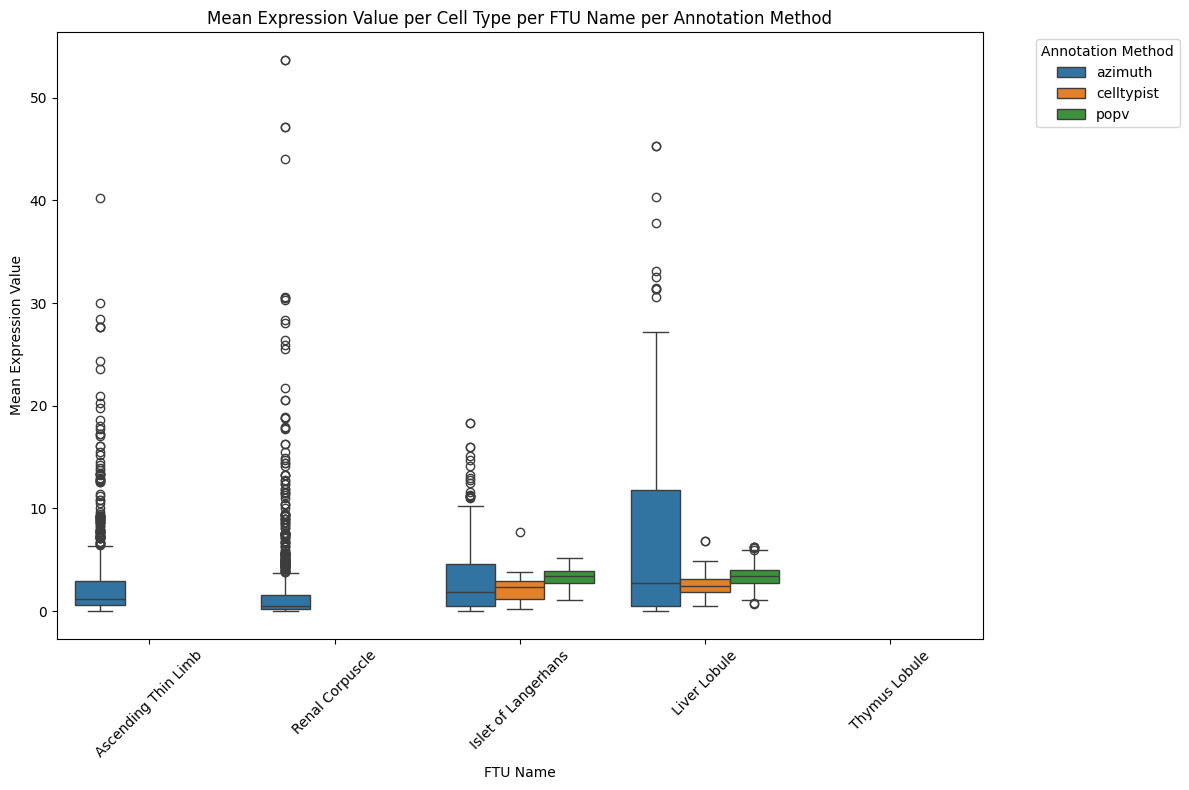

In [74]:
# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='FTU_name', y='mean_expr_value', hue='annotation_method', data=matches_df_filtered)

# Customize the plot
plt.title('Mean Expression Value per Cell Type per FTU Name per Annotation Method')
plt.xlabel('FTU Name')
plt.ylabel('Mean Expression Value')
plt.xticks(rotation=45)
plt.legend(title='Annotation Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot to a file
output_file_path = 'output/vasculature/mean-expression-box-plot-per-CT-per-FTU-per-AnnMethod.png'
plt.tight_layout()
plt.savefig(output_file_path)
plt.show()

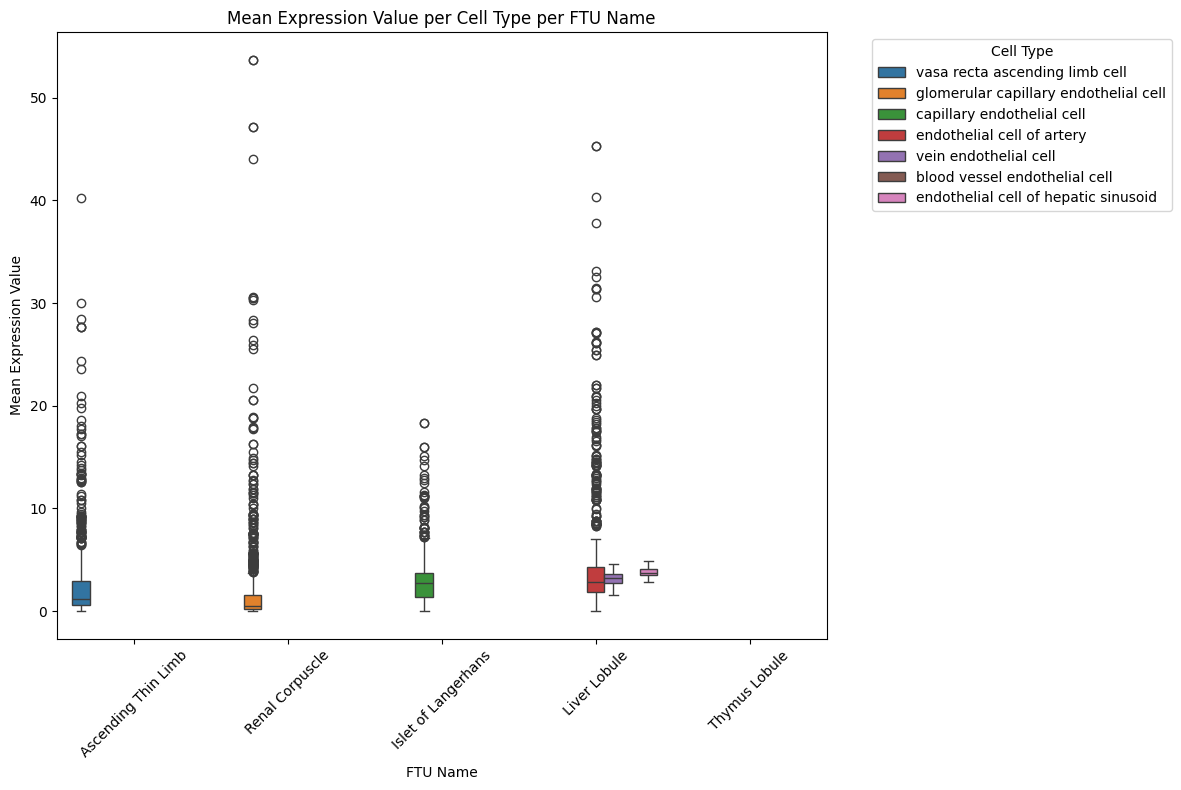

In [75]:
# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='FTU_name', y='mean_expr_value', hue='cell_label', data=matches_df_filtered)

# Customize the plot
plt.title('Mean Expression Value per Cell Type per FTU Name')
plt.xlabel('FTU Name')
plt.ylabel('Mean Expression Value')
plt.xticks(rotation=45)
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot to a file
output_file_path = 'output/vasculature/mean_expression_box_plot_per_cell_type.png'
plt.tight_layout()
plt.savefig(output_file_path)
plt.show()

### Understand the JSON files

In [ ]:
file_path = 'ref_data/atlas-enriched-dataset-graph.jsonld'

with open(file_path, 'r') as file:
    data = json.load(file)

In [ ]:
# Function to extract as_label, link, and cell_id from the JSON data
def extract_all_entries(json_data):
    result = []
    for entry in json_data['@graph']:
        for sample in entry.get('samples', []):
            rui_location = sample.get('rui_location', {})
            all_collisions = rui_location.get('all_collisions', [])
            for collision in all_collisions:
                collisions = collision.get('collisions', [])
                for col in collisions:
                    as_label = col.get('as_label', 'unknown')
                    for section in sample.get('sections', []):
                        for dataset in section.get('datasets', []):
                            link = dataset.get('link', 'unknown')
                            for summary in dataset.get('summaries', []):
                                for summary_item in summary.get('summary', []):
                                    cell_id = summary_item.get('cell_id', 'unknown')
                                    cell_label = summary_item.get('cell_label', 'unknown')
                                    new_row = {
                                        'as_label': as_label,
                                        'link': link,
                                        'cell_label': cell_label,
                                        'cell_id': cell_id
                                    }
                                    result.append(new_row)
    return result

# Extract all entries
extracted_data_enriched = extract_all_entries(json_data_enriched)

# Convert extracted data to a DataFrame
extracted_df_enriched = pd.DataFrame(extracted_data_enriched)

# Display the DataFrame's head
print(extracted_df_enriched.head())

In [ ]:
extracted_df.to_csv('output/Dataset-source-cell-enriched.csv', index=False)

In [ ]:
# Extract cell IDs from the summary section
def extract_cell_ids(data):
    cell_ids = []
    for item in data['@graph']:
        samples = item.get("samples", [])
        for sample in samples:
            sections = sample.get("sections", [])
            for section in sections:
                datasets = section.get("datasets", [])
                for dataset in datasets:
                    summaries = dataset.get("summaries", [])               
                    for summary in summaries:
                        sum_details = summary.get("summary", [])
                        for sum_detail in sum_details:
                            cell_id = sum_detail.get("cell_id")
                            cell_ids.append(cell_id)
    return cell_ids

cell_ids = extract_cell_ids(json_data_enriched)
print(f"Cell IDs from the file: {len(cell_ids)}")

In [ ]:
def extract_cell_ids_summaries(data):
    cell_ids = []
    for item in data['@graph']:
        summaries = item.get('summary', [])
        for summary in summaries:
            for detail in summary:
                if 'cell_id' in detail:
                    cell_ids.append(summary['cell_id'])
    return cell_ids

cell_ids_summaries = extract_cell_ids_summaries(json_data_summary)
print(f"Cell IDs from the file: {len(cell_ids_summaries)}")

In [ ]:
# Function to extract aggregated_summaries, cell_source_label, cell_label, and cell_id from the JSON data
graph_data = json_data_summary.get('@graph', [])

extracted_data_summary = []

for item in graph_data:
    if 'summary' in item:
        for summary in item['summary']:
            for summary in summaries:
                if 'cell_id' in summary and 'cell_label' in summary:
                    for aggregated_summary in aggregated_summaries:
                        extracted_entry = {
                    'cell_source_label': cell_source_label,
                    'aggregated_summary': aggregated_summary,
                    'cell_label': summary.get('cell_label'),
                    'cell_id': summary.get('cell_id')
                }
                extracted_data_summary.append(extracted_entry)

# Convert extracted data to a DataFrame
extracted_df_summary = pd.DataFrame(extracted_data_summary)

# Display the DataFrame's head
print(extracted_df_summary.head())


In [ ]:
extracted_df_summary.to_csv('output/Dataset-source-cell-summary.csv', index=False)

  annotation_method                          y_label_clean     sex  \
0           azimuth         LeftKidneyV1.1_hilum of kidney  Female   
1           azimuth          LeftKidneyV1.1_kidney capsule  Female   
2           azimuth  LeftKidneyV1.1_outer cortex of kidney  Female   
3           azimuth            LeftKidneyV1.1_renal column  Female   
4           azimuth           LeftKidneyV1.1_renal pyramid  Female   

   unique_dataset_count  
0                     1  
1                     2  
2                     8  
3                     3  
4                    26  


C:\Users\Supriya\AppData\Local\Temp\ipykernel_20248\3117018886.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g_combined = sns.catplot(


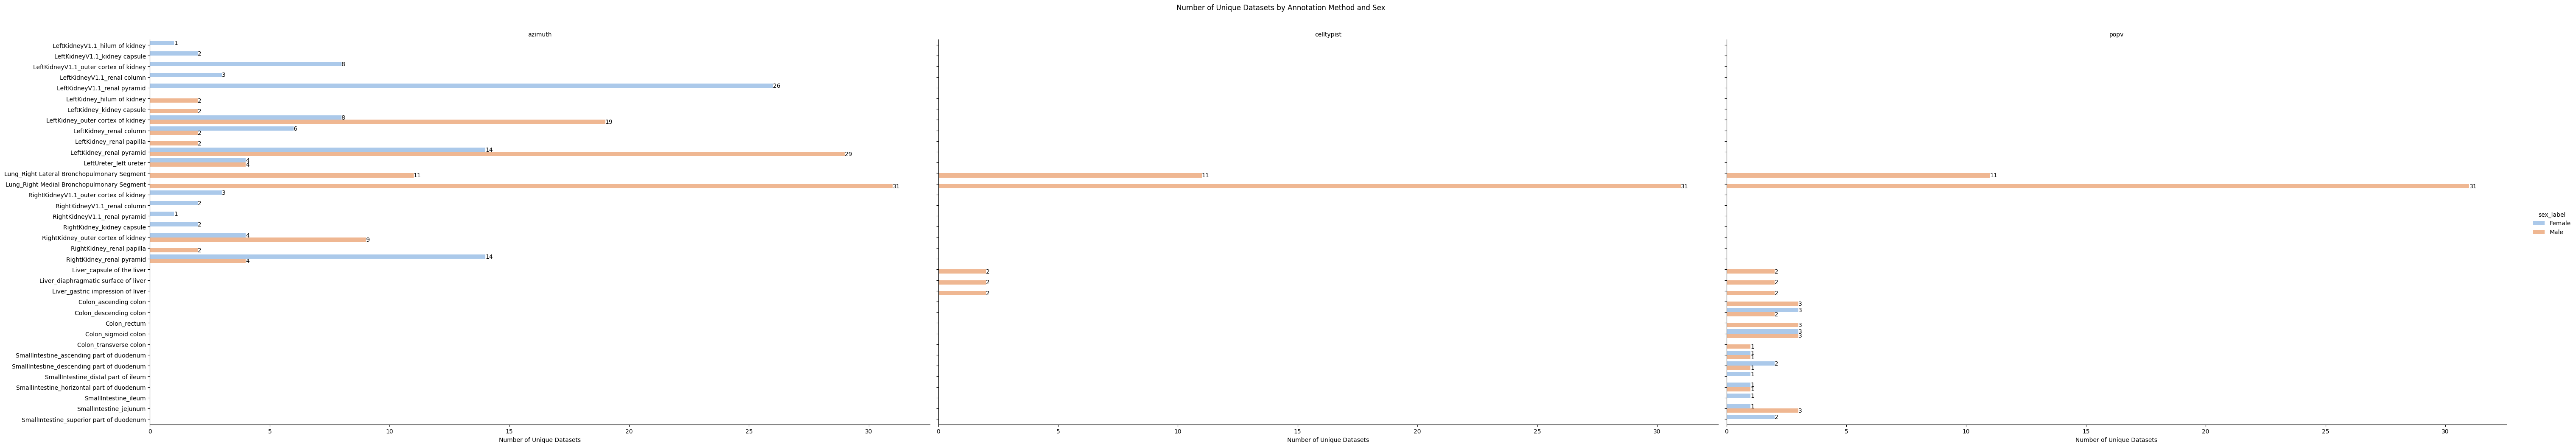

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

latest_filtered_cts_df = filtered_result_df.copy()

# Extract the relevant part of the reference_organ (after '#VHF')
latest_filtered_cts_df['reference_organ_clean'] = latest_filtered_cts_df['reference_organ'].apply(lambda x: x.split('#')[-1])

# Remove 'VHF' or 'VHM' from the 'reference_organ_clean' field
latest_filtered_cts_df['reference_organ_clean'] = latest_filtered_cts_df['reference_organ_clean'].str.replace('VHF', '').str.replace('VHM', '')

# Create a new column combining reference_organ_clean and as_label
latest_filtered_cts_df['y_label_clean'] = latest_filtered_cts_df['reference_organ_clean'] + "_" + latest_filtered_cts_df['as_label']

# Count the number of unique datasets per reference_organ + as_label combination for each annotation_method
latest_dataset_counts = latest_filtered_cts_df.groupby(['annotation_method', 'y_label_clean', 'sex']).dataset.nunique().reset_index()
latest_dataset_counts = latest_dataset_counts.rename(columns={'dataset': 'unique_dataset_count'})

# Debug: Check the unique dataset counts
print(latest_dataset_counts.head())

# Combine the male and female dataframes and create a new column for sex
latest_dataset_counts_combined = latest_dataset_counts.copy()
latest_dataset_counts_combined['sex_label'] = latest_dataset_counts_combined['sex']

# Define a custom color palette for better visualization
custom_palette = sns.color_palette("pastel")

g_combined = sns.catplot(
    data=latest_dataset_counts_combined,
    x="unique_dataset_count", y="y_label_clean", hue="sex_label",
    col="annotation_method", kind="bar",
    height=10, aspect=2, col_wrap=3,
    palette=custom_palette
)

g_combined.set_axis_labels("Number of Unique Datasets", "")
g_combined.set_titles("{col_name}")
g_combined.fig.suptitle("Number of Unique Datasets by Annotation Method and Sex", y=1.05)

# Annotate the bars with the number of unique datasets, handling NaN values
for ax in g_combined.axes.flatten():
    for c in ax.containers:
        labels = [f'{int(v.get_width()):.0f}' if not pd.isna(v.get_width()) else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')

# Save the plot as a high-resolution image
g_combined.savefig("output/figures/Datasets-AS-Annotation-Sex.png", dpi=300)

plt.show()

C:\Users\Supriya\AppData\Local\Temp\ipykernel_20248\950318833.py:2: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.violinplot(


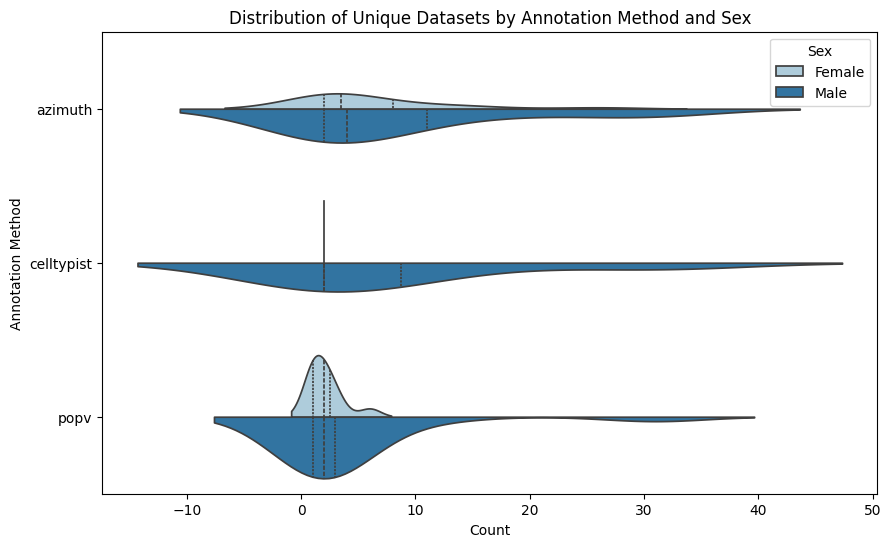

In [82]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=latest_dataset_counts_combined,
    x="unique_dataset_count", y="annotation_method", hue="sex_label",
    split=True, inner="quart", palette=custom_palette
)

plt.title("Distribution of Unique Datasets by Annotation Method and Sex")
plt.xlabel("Count")
plt.ylabel("Annotation Method")
plt.legend(title="Sex")
plt.show()